<a href="https://colab.research.google.com/github/sayalaruano/CapstoneProject-MLZoomCamp/blob/main/EDA_Binary_classifiers_AMPs_activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting cardiomyopathies using RNAseq data with machine learning models**

This notebook is part of a group project for the Systems Biology masters at Maastricht University.

You can find more details about my capstone project in this [GitHub repository](https://github.com/sayalaruano/Project3Period-SysBioMaster).

## Dataset description
We will be using an [RNA-sequencing dataset from the MAGNet consortium](https://github.com/mpmorley/MAGNet). To generate this dataset, leftventricular free-wall tissue was harvested at the time of cardiac surgery fromsubjects with heart failure undergoing transplantation and from unused donor hearts with apparently normal function.  This dataset is a spectacular resource of left ventricular transcriptomes of **non-failing healthy donors**, 
**Peripartum cardiomyopathy (PPCM)**, **Hypertrophic cardiomyopathy (HCM)** and **Dilated cardiomyopathy (DCM)** patients. Next to the RNA-sequencing data (in log2-transformed CPM values), extensive participant information is available (age, sex, ethnicity, disease state, and so on).

**Note:** `mkdir`, `wget`, `unzip`, `make`, `cd`, `grep`, and `cat` are Unix based OS commands, so if you are in Windows, maybe these terminal tools won't work.

## **Installation of libraries**

### **[LazyPredict](https://github.com/shankarpandala/lazypredict)**
Library to run many sklearn's binary classifiers with default parameters

In [1]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Imports, data obtention, and pre-processing**

In [15]:
# Download and unzip 
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

# Data manipulation and EDA
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning classifers
import lazypredict
import pickle
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import make_scorer

In [3]:
# Download and unzip data
def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

url = "https://surfdrive.surf.nl/files/index.php/s/mZrXMDlQ1Z1LvTn/download"

download_and_unzip(url, extract_to='.')

## **Feature matrices preparation**


### **Load molecular descriptors (features)**

In [4]:
# Load gene expression and sampleinfo data 
gxData_cpm = pd.read_table("MAGNET_GeneExpressionData_CPM_19112020.txt", index_col=0)

sampleInfo = pd.read_csv("MAGNET_SampleData_18112022.csv")

In [5]:
# Transpose the gx dataframe
gxData_cpm = gxData_cpm.transpose()

# Create a new column with index values 
gxData_cpm = gxData_cpm.rename_axis('sample_name').reset_index()

# Rename the index name
gxData_cpm = gxData_cpm.rename_axis(None, axis=1)

In [6]:
# Get a df with the etiology and sample name columns 
columns = ["etiology", "sample_name"]

etiology = sampleInfo[columns]

In [7]:
# Join the etiology and gx dataframes
gxData_cpm_labeled = pd.merge(gxData_cpm, etiology, on='sample_name', how='inner')

In [8]:
# Prin the number of samples per etiology
gxData_cpm_labeled["etiology"].value_counts()

NF      166
DCM     166
HCM      28
PPCM      6
Name: etiology, dtype: int64

In [9]:
# Select the NF and DCM patients
gxData_cpm_lab_NFHCM = gxData_cpm_labeled[(gxData_cpm_labeled["etiology"] == "NF") | 
                                          (gxData_cpm_labeled["etiology"] == "HCM")]

In [10]:
# Create the y label dataset
y = gxData_cpm_lab_NFHCM['etiology'].copy()

# Encoding the target class label
y = y.map({"HCM": 1, "NF": 0}).to_numpy()

In [11]:
# Create the feature matrix by deleting the y column and the sample name
final_df_NFHCM = gxData_cpm_lab_NFHCM.drop(['etiology', 'sample_name'], axis=1)
X = final_df_NFHCM.to_numpy()

## **Exploratory Data Analysis**

### **Target variable**

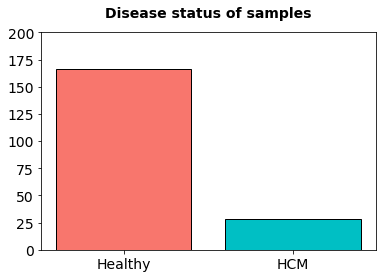

In [13]:
# Bar plot of active and inactive AMPs

# Data
n_healthy = (gxData_cpm_lab_NFHCM["etiology"] == "NF").sum()
n_disease = (gxData_cpm_lab_NFHCM["etiology"] == "HCM").sum()

x_label = ['Healthy', 'HCM']
y_label = [n_healthy, n_disease]

# Setup plot
fig, ax = plt.subplots()

# Make bar plot
p = ax.bar(x_label, y_label, color = ['#F8766D', '#00BFC4'], ec = 'black')

ax.set_title('Disease status of samples', fontsize=14, fontweight='bold', pad=15)

ax.set_ylim(0,200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## **Machine learning models**
First, we tested more than 30 ML binary classifiers using the [LazyPredict](https://github.com/shankarpandala/lazypredict) Python library. We chose the best model evaluating some performance metrics (e.g., accuracy, ROC AUC, F1 score, and Matthews Correlation Coefficient) on the test dataset. 

In [14]:
# Run the ML classifiers with LazyPredict     
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state =42, 
                                                    stratify=y)

# Define and build the Lazyclassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=matthews_corrcoef)

models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [01:14<00:00,  2.57s/it]


In [ ]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,matthews_corrcoef,Time Taken
Model,,,,,,
LinearDiscriminantAnalysis,1.00,1.00,1.00,1.00,1.00,1.72
SGDClassifier,0.97,0.98,0.98,0.98,0.91,0.65
Perceptron,0.97,0.98,0.98,0.98,0.91,0.65
LinearSVC,0.95,0.97,0.97,0.95,0.84,1.14
PassiveAggressiveClassifier,0.95,0.97,0.97,0.95,0.84,0.84
RidgeClassifierCV,0.97,0.92,0.92,0.97,0.90,0.74
RidgeClassifier,0.97,0.92,0.92,0.97,0.90,0.63
LogisticRegression,0.97,0.92,0.92,0.97,0.90,1.68
LGBMClassifier,0.97,0.92,0.92,0.97,0.90,19.82


[(0.0, 1.0)]

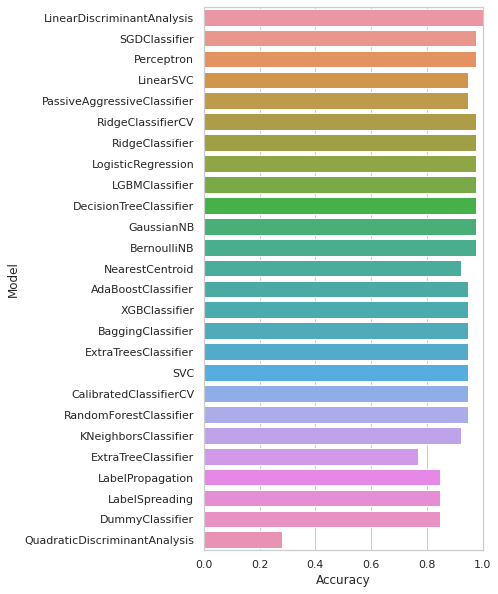

In [ ]:
# Plot of Accuracy
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=models.index, x="Accuracy", 
                 data=models)
ax.set(xlim=(0, 1))

[(0.0, 1.0)]

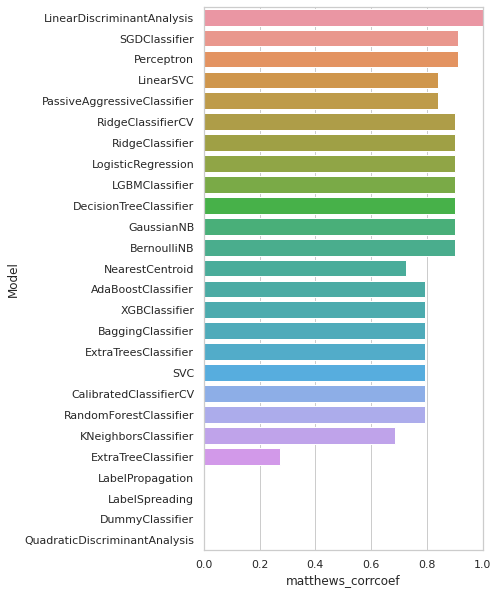

In [ ]:
# Plot of MCC
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=models.index, 
                 x="matthews_corrcoef", data=models)
ax.set(xlim=(0, 1))

---
We did not fine-tuned the hyperparameters of the best model because the performance metrics with the default parameters were very high, so hyperparameter tuning was not necessary.

### **Evaluation of the best model on the test dataset**
According to the summary tables presented above, there were some models with a perfect prediction capcity considering all of the performance metrics (values of 1 in the previous table). However, these methods are based on regression classifiers, which cannot show the feature importance of the model. So, we used the **RandomForestClassifier** that also have high performance metrics values and keep track of the feature importance (in this case, the gene expression values).

Thus, we trained this model again on the entire training dataset (without creating the validation partition) and evaluated it on the **test dataset**. 

In [ ]:
clf.models["DecisionTreeClassifier"]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            20771, 20772, 20773, 20774, 20775, 20776, 20777, 20778, 20779,
            20780],
           dtype='int64', length=20781)),
                                                 ('categorical_low',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                               

In [16]:
# Implementation of the best models
best_model1 = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=42))
best_model1.fit(X_train, y_train)

best_model2 = make_pipeline(StandardScaler(), LGBMClassifier(random_state=42))
best_model2.fit(X_train, y_train)

best_model3 = make_pipeline(StandardScaler(), XGBClassifier(random_state=42))
best_model3.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier', XGBClassifier(random_state=42))])

In [ ]:
# Predicting values with the best model on test and external datasets
y_test_pred = best_model1.predict(X_test)

In [ ]:
# Dataset to store performance metrics
results_bestMLmodel = pd.DataFrame()

In [ ]:
# Calculate performance metrics
roc_auc_test = roc_auc_score(y_test, y_test_pred)

acc_test = accuracy_score(y_test, y_test_pred)

prec_test = precision_score(y_test, y_test_pred)

recall_test = recall_score(y_test, y_test_pred)

f1score_test = f1_score(y_test, y_test_pred)

mcc_test = matthews_corrcoef(y_test, y_test_pred)

# Add columns to the dataset
results_bestMLmodel["Performance_metric"] = ['ROC_AUC','Accuracy', 'Precision', 
                                             'Recall', 'F1score', 'MCC']

results_bestMLmodel["Test_dataset"] = [roc_auc_test, acc_test, prec_test, 
                                       recall_test, f1score_test, mcc_test]

In [ ]:
# Show the evaluation results of the best model
results_bestMLmodel

,Performance_metric,Test_dataset
0,ROC_AUC,0.92
1,Accuracy,0.97
2,Precision,1.00
3,Recall,0.83
4,F1score,0.91
5,MCC,0.90


In [ ]:
results_bestMLmodel.to_csv("evaluation_bestMLclassifier.csv")

In [ ]:
best_model[1].feature_importances_

array([0, 1, 0, ..., 0, 0, 0])

### **Feature importance of the best model**

In [18]:
# Retrieve feature importance from the best models
importance_bestmodel1 = pd.Series(best_model1[1].feature_importances_, name = 'Gini')
importance_bestmodel2 = pd.Series(best_model2[1].feature_importances_, name = 'Importance (split)')
importance_bestmodel3 = pd.Series(best_model3[1].feature_importances_, name = 'Importance (weight)')

# Retrieve feature names
feature_names = pd.Series(final_df_NFHCM.columns, name = 'Feature')

In [19]:
# Combine feature names and Gini values into a Dataframe
feat_import_bestmodel1 = pd.concat([feature_names, importance_bestmodel1], axis=1, names=['Feature', 'Gini'])
feat_import_bestmodel2 = pd.concat([feature_names, importance_bestmodel2], axis=1, names=['Feature', 'Importance (split)'])
feat_import_bestmodel3 = pd.concat([feature_names, importance_bestmodel3], axis=1, names=['Feature', 'Importance (weight)'])

# Sort the dataframe by Gini in descending order
featimp_bestmodel1_sort = feat_import_bestmodel1.sort_values('Gini', ascending=False)
featimp_bestmodel2_sort = feat_import_bestmodel2.sort_values('Importance (split)', ascending=False)
featimp_bestmodel3_sort = feat_import_bestmodel3.sort_values('Importance (weight)', ascending=False)

In [20]:
featimp_bestmodel1_sort

,Feature,Gini
9421,ENSG00000162998,0.90
3627,ENSG00000112562,0.10
0,ENSG00000000003,0.00
13854,ENSG00000196923,0.00
13861,ENSG00000196951,0.00
...,...,...
6926,ENSG00000140181,0.00
6925,ENSG00000140157,0.00
6924,ENSG00000140153,0.00
6923,ENSG00000140105,0.00


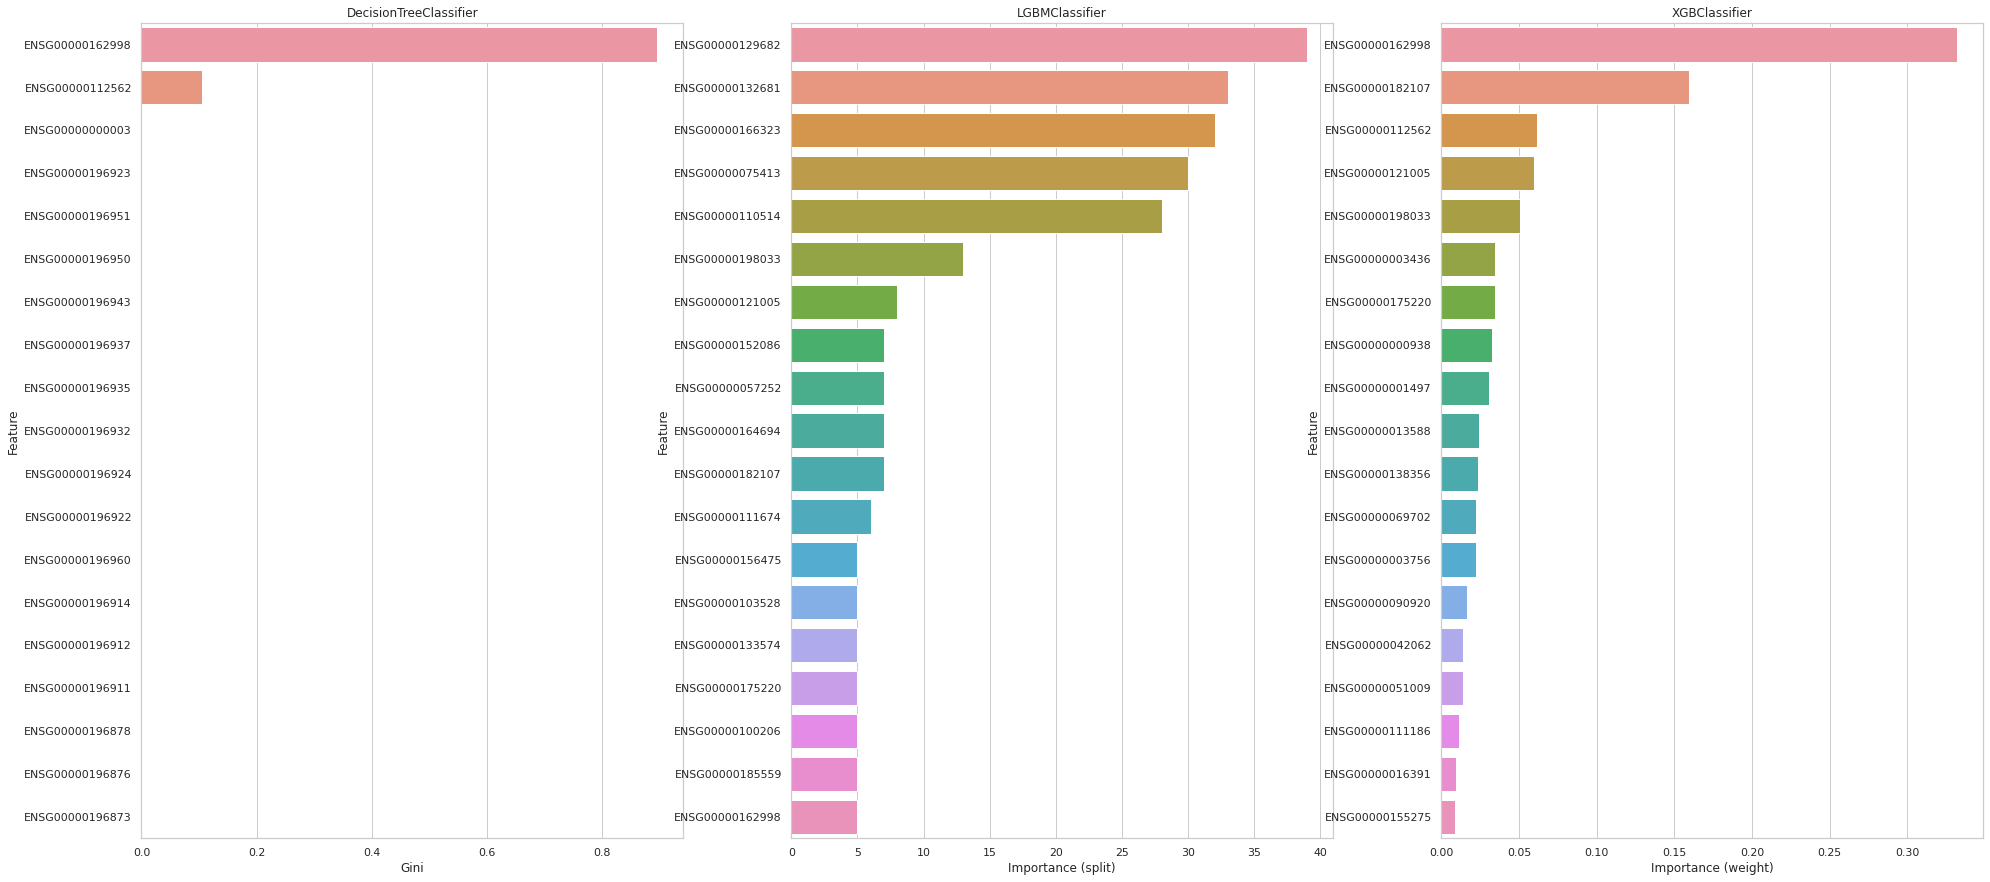

In [21]:
# Plot of feature importance of the 3 algorithms
#plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(33, 15))

sns.barplot(ax = ax1, x = 'Gini', y = 'Feature', data = featimp_bestmodel1_sort.iloc[0:19])
ax1.title.set_text('DecisionTreeClassifier')
sns.barplot(ax = ax2, x = 'Importance (split)', y = 'Feature', data = featimp_bestmodel2_sort.iloc[0:19])
ax2.title.set_text('LGBMClassifier')
sns.barplot(ax = ax3, x = 'Importance (weight)', y = 'Feature', data = featimp_bestmodel3_sort.iloc[0:19])
ax3.title.set_text('XGBClassifier')

The feature importance results show that most of the genes have low Gini impurity values, which means that all elements belong to a certain class and there are not highly important genes that helps to the classification task.

### **Save the best model into a file**

In [ ]:
# Define the output file's name
output_file = f'RandomForestClassifier_NF_DCM'
output_file

'RandomForestClassifier_NF_DCM'

In [ ]:
# Export the binary file of the best model
with open(output_file, "wb") as f_out:
    pickle.dump(best_model[1], f_out)

---